In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset paths
train_data_path = "/content/drive/MyDrive/dataset/AMA_NET/archive (7)/kag2"
test_data_path = "/content/drive/MyDrive/dataset/AMA_NET/archive (7)/crop_images"

# Model Parameters
num_classes = 5
img_size = (224, 224)
batch_size = 36
epochs = 30  # Increased epochs for better convergence
learning_rate = 1e-3  # Adjusted learning rate for fine-tuning

# Normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to Load Train & Test Data

def load_agriculture_crop_dataset():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=lambda x: (x - mean) / std
    )
    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=lambda x: (x - mean) / std
    )
    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    print(f"Train Data Size: {train_generator.samples}")
    print(f"Test Data Size: {test_generator.samples}")

    return train_generator, test_generator

# Adaptive Masking Module
class AdaptiveMaskingModule(layers.Layer):
    def __init__(self, in_channels):
        super(AdaptiveMaskingModule, self).__init__()
        self.conv1 = layers.Conv2D(in_channels // 2, (1,1), activation='relu')
        self.conv2 = layers.Conv2D(1, (1,1), activation='sigmoid')
        self.bn = layers.BatchNormalization()

    def call(self, x):
        mask = self.conv1(x)
        mask = self.conv2(mask)
        mask = self.bn(mask)
        mask = tf.where(mask > 0.5, 1.0, 0.0)
        return x * mask + x  # Residual connection

# Fair Attention Module
class FairAttentionModule(layers.Layer):
    def __init__(self):
        super(FairAttentionModule, self).__init__()
        self.conv = layers.Conv2D(2048, (1, 1), activation='relu')
        self.bn = layers.BatchNormalization()
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        attention_scores = self.sigmoid(tf.reduce_mean(self.conv(x), axis=-1, keepdims=True))
        return x * attention_scores + x

# AMA-Net Model
class AMA_Net(models.Model):
    def __init__(self, num_classes=5):
        super(AMA_Net, self).__init__()
        base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        for layer in base_model.layers[:-20]:  # Fine-tune last 20 layers
            layer.trainable = False

        self.backbone = models.Model(inputs=base_model.input, outputs=base_model.output)
        self.am_module = AdaptiveMaskingModule(in_channels=2048)
        self.fa_module = FairAttentionModule()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.4)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        features = self.backbone(inputs)
        refined_features = self.am_module(features)
        enhanced_features = self.fa_module(refined_features)
        pooled_features = self.global_pool(enhanced_features)
        dropped_features = self.dropout(pooled_features)
        return self.classifier(dropped_features)

# Training and Evaluation
if __name__ == "__main__":
    train_data, test_data = load_agriculture_crop_dataset()
    num_classes = len(train_data.class_indices)

    model = AMA_Net(num_classes=num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    model.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[early_stopping, lr_scheduler])

    # Evaluate Model
    # evaluate_metrics(model, test_data)


Found 813 images belonging to 5 classes.
Found 201 images belonging to 5 classes.
Train Data Size: 813
Test Data Size: 201
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'fair_attention_module', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['ama__net/adaptive_masking_module/conv2d/kernel', 'ama__net/adaptive_masking_module/conv2d/bias', 'ama__net/adaptive_masking_module/conv2d_1/kernel', 'ama__net/adaptive_masking_module/conv2d_1/bias', 'ama__net/adaptive_masking_module/batch_normalization/gamma', 'ama__net/adaptive_masking_module/batch_normalization/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.

23/23 ━━━━━━━━━━━━━━━━━━━━ 315s 13s/step - accuracy: 0.2277 - loss: 2.6175 - val_accuracy: 0.2886 - val_loss: 1.4895 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 250s 11s/step - accuracy: 0.3271 - loss: 1.4904 - val_accuracy: 0.4826 - val_loss: 1.3036 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 253s 11s/step - accuracy: 0.4550 - loss: 1.3255 - val_accuracy: 0.5771 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 255s 11s/step - accuracy: 0.4979 - loss: 1.2165 - val_accuracy: 0.5572 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 246s 11s/step - accuracy: 0.5690 - loss: 1.0585 - val_accuracy: 0.5572 - val_loss: 1.1222 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 245s 11s/step - accuracy: 0.6070 - loss: 1.0580 - val_accuracy: 0.6617 - val_loss: 0.8813 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 250s 11s/step - accuracy: 0.5942 - loss: 1.0469 - val_accurac

NameError: name 'evaluate_metrics' is not defined

In [ ]:
# ✅ Function to Evaluate Model Performance
def evaluate_metrics(model, test_data):
    y_true = []
    y_pred_probs = []

    for x_batch, y_batch in test_data:
        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class labels
        y_pred_probs.extend(model.predict(x_batch))  # ✅ Get probability outputs

        # Stop when we process all test samples
        if len(y_true) >= test_data.samples:
            break

    # Convert probability outputs to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute standard classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")

    # Convert y_true to one-hot encoding
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=5)
    y_pred_probs = np.array(y_pred_probs)  # Convert to NumPy array

    # ✅ Compute ROC Curve for Multi-Class (One vs Rest)
    plt.figure(figsize=(8, 6))
    for i in range(5):  # 5 classes
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # ✅ Compute Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for i in range(5):  # 5 classes
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        plt.plot(recall_curve, precision_curve, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 605ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 604ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 618ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Accuracy: 0.9701
✅ Precision: 0.9717
✅ Recall: 0.9701
✅ F1-Score: 0.9703


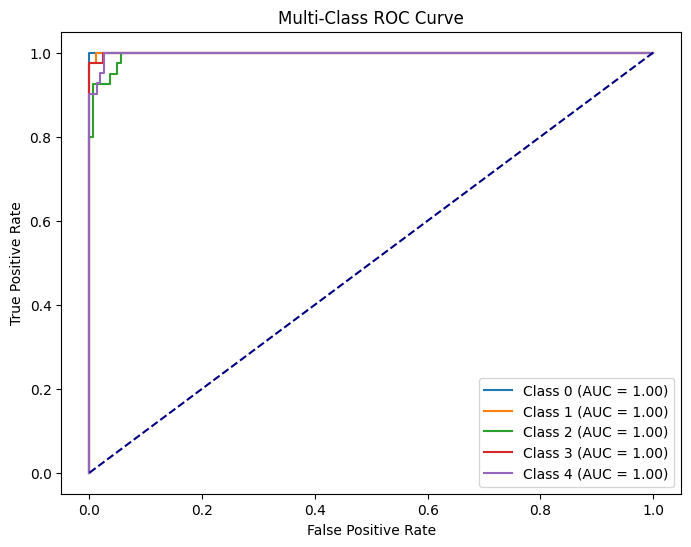

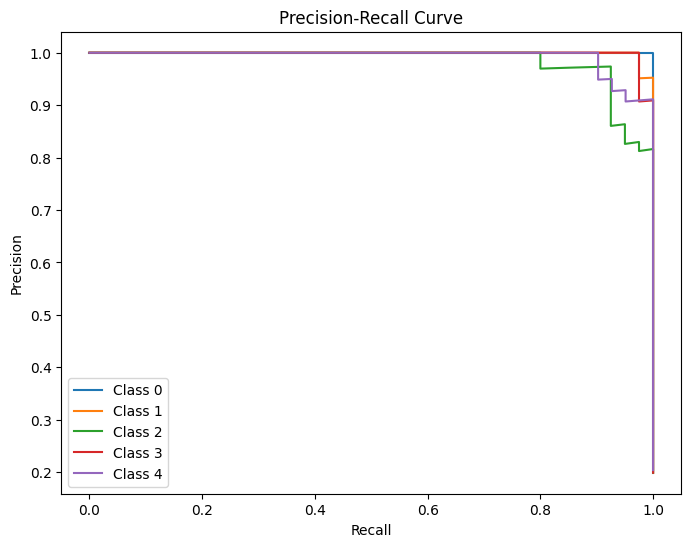

In [ ]:
# Evaluate Model
evaluate_metrics(model, test_data)

Only for 2 class sugarcane and rice (Train on AMA-NET AND TESTING ON SIR'S DATA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Dataset Paths (Use your original structure)
train_data_path = "/content/drive/MyDrive/dataset/AMA_NET/archive (7)/kag2"
test_data_path = "/content/drive/MyDrive/dataset/Train_test_data"

# ✅ Model Parameters
num_classes = 2  # Update if necessary
img_size = (224, 224)
batch_size = 36
epochs = 30
learning_rate = 1e-3

# ✅ Normalization Values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# ✅ Load Data (Using Full Dataset Without Splitting)
def load_agriculture_crop_dataset():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=lambda x: (x - mean) / std
    )
    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=lambda x: (x - mean) / std
    )
    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    print(f"✅ Train Data Size: {train_generator.samples}")
    print(f"✅ Test Data Size: {test_generator.samples}")

    return train_generator, test_generator

# ✅ Adaptive Masking Module (Using Softmax)
class AdaptiveMaskingModule(layers.Layer):
    def __init__(self, in_channels):
        super(AdaptiveMaskingModule, self).__init__()
        self.conv1 = layers.Conv2D(in_channels // 2, (1, 1), activation='relu')
        self.conv2 = layers.Conv2D(1, (1, 1))
        self.bn = layers.BatchNormalization()

    def call(self, x):
        mask = self.conv1(x)
        mask = self.conv2(mask)
        mask = self.bn(mask)
        mask = tf.nn.softmax(mask, axis=-1)  # ✅ Softmax Activation
        return x * mask + x  # Residual Connection

# ✅ Fair Attention Module (Using Softmax)
class FairAttentionModule(layers.Layer):
    def __init__(self):
        super(FairAttentionModule, self).__init__()
        self.conv = layers.Conv2D(2048, (1, 1), activation='relu')
        self.bn = layers.BatchNormalization()

    def call(self, x):
        attention_scores = self.conv(x)
        attention_scores = self.bn(attention_scores)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)  # ✅ Softmax Activation
        return x * attention_scores + x

# ✅ AMA-Net Model
class AMA_Net(models.Model):
    def __init__(self, num_classes=5):
        super(AMA_Net, self).__init__()
        base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

        for layer in base_model.layers[:-20]:
            layer.trainable = False

        self.backbone = models.Model(inputs=base_model.input, outputs=base_model.output)
        self.am_module = AdaptiveMaskingModule(in_channels=2048)
        self.fa_module = FairAttentionModule()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.4)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        features = self.backbone(inputs)
        refined_features = self.am_module(features)
        enhanced_features = self.fa_module(refined_features)
        pooled_features = self.global_pool(enhanced_features)
        dropped_features = self.dropout(pooled_features)
        return self.classifier(dropped_features)

# ✅ Training and Evaluation
if __name__ == "__main__":
    train_data, test_data = load_agriculture_crop_dataset()
    num_classes = len(train_data.class_indices)

    model = AMA_Net(num_classes=num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    model.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[early_stopping, lr_scheduler])

    test_loss, test_acc = model.evaluate(test_data)
    print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


Found 329 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
✅ Train Data Size: 329
✅ Test Data Size: 158


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4959 - loss: 6.2617 - val_accuracy: 0.4937 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.5405 - loss: 0.7842 - val_accuracy: 1.0000 - val_loss: 0.3518 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 705ms/step - accuracy: 0.5729 - loss: 0.6715 - val_accuracy: 1.0000 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 588ms/step - accuracy: 0.6151 - loss: 0.6499 - val_accuracy: 1.0000 - val_loss: 0.2731 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - accuracy: 0.6709 - loss: 0.5920 - val_accuracy: 1.0000 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 580ms/step - accuracy: 0.6260 - loss: 0.6669 - val_accuracy: 1.0000 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 682ms/step - accuracy: 0.7263 - loss: 0.5245 - va

In [ ]:
# ✅ Function to Evaluate Model Performance
def evaluate_metrics(model, test_data):
    y_true = []
    y_pred_probs = []

    for x_batch, y_batch in test_data:
        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class labels
        y_pred_probs.extend(model.predict(x_batch))  # ✅ Get probability outputs

        # Stop when we process all test samples
        if len(y_true) >= test_data.samples:
            break

    # Convert probability outputs to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute standard classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")

    # Convert y_true to one-hot encoding
    # Change num_classes to reflect the actual number of classes in your data
    num_classes_in_data = test_data.num_classes  # Get the actual number of classes
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=num_classes_in_data)
    y_pred_probs = np.array(y_pred_probs)  # Convert to NumPy array

    # ✅ Compute ROC Curve for Multi-Class (One vs Rest)
    plt.figure(figsize=(8, 6))
    # Iterate through the actual number of classes
    for i in range(num_classes_in_data):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # ✅ Compute Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    # Iterate through the actual number of classes
    for i in range(num_classes_in_data):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        plt.plot(recall_curve, precision_curve, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()


In [ ]:
# Evaluate Model
evaluate_metrics(model, test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


NameError: name 'accuracy_score' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# ✅ Function to Unnormalize and Display Image
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to valid range
    return img

# ✅ Load a batch from the test dataset
test_batch = next(iter(test_data))  # Extract batch from test dataset
images, labels = test_batch  # Unpack images and labels

# ✅ Get model predictions
pred_probs = model.predict(images)  # Get probability outputs

# Convert predictions to class labels (binary case)
if pred_probs.shape[1] == 2:  # Check if softmax output has 2 values per sample
    preds = np.argmax(pred_probs, axis=1)  # Take the class with highest probability
else:
    preds = (pred_probs > 0.5).astype(int)  # For sigmoid output, threshold at 0.5

# Convert labels to class indices if one-hot encoded
if labels.shape[-1] == 2:
    true_labels = np.argmax(labels, axis=1)  # Convert from one-hot to class index
else:
    true_labels = labels.squeeze()  # Remove extra dimensions

# ✅ Define number of images to display (max 9)
num_images = min(len(images), 9)

# ✅ Create Subplots (3x3 Grid)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    ax = axes[i // 3, i % 3]  # Get subplot position
    if i < num_images:
        img = images[i].numpy()  # Convert Tensor to NumPy
        ax.imshow(imshow(img))  # Unnormalize and display image
        ax.set_title(f"Pred: {preds[i]} / True: {true_labels[i]}", fontsize=12)
        ax.axis("off")
    else:
        ax.axis("off")  # Hide extra plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to Unnormalize and Display Image
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Reshape mean and std to match the image shape
    mean = mean.reshape(1, 1, 3)  # Reshape to (1, 1, 3) for broadcasting
    std = std.reshape(1, 1, 3)   # Reshape to (1, 1, 3) for broadcasting

    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to valid range
    # Transpose the image back to the original channel order
    img = img.transpose(2, 0, 1)  # Change from (H, W, C) to (C, H, W)

    return img

# Load a batch from the test dataset
test_batch = next(iter(test_data))  # Extract batch from test dataset
images, labels = test_batch  # Unpack images and labels

# Get model predictions
pred_probs = model.predict(images)  # Get probability outputs
preds = np.argmax(pred_probs, axis=1)  # Convert to class labels

# Define number of images to display (max 9)
num_images = min(len(images), 9)

# Create Subplots (3x3 Grid)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    ax = axes[i // 3, i % 3]  # Get subplot position
    if i < num_images:
        img = images[i]  # images is already a NumPy array
        # The image is already in (C, H, W) format, no need to transpose here
        ax.imshow(imshow(img))
        ax.set_title(f"Pred: {preds[i]} / True: {np.argmax(labels[i])}", fontsize=12)
        ax.axis("off")
    else:
        ax.axis("off")  # Hide extra plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to Unnormalize and Display Image
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Reshape mean and std to match the image shape
    mean = mean.reshape(1, 1, 3)  # Reshape to (1, 1, 3) for broadcasting
    std = std.reshape(1, 1, 3)   # Reshape to (1, 1, 3) for broadcasting

    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to valid range
    # Transpose the image to the correct channel order for Matplotlib
    img = img.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

    return img

# ... (rest of your code remains the same)